Clustering of unlabeled data can be performed with the module sklearn.cluster.

Each clustering algorithm comes in two variants: a class, that implements the fit method to learn the clusters on train data, and a function, that, given train data, returns an array of integer labels corresponding to the different clusters. For the class, the labels over the training data can be found in the labels_ attribute.

### Input :

One important thing to note is that the algorithms implemented in this module can take different kinds of matrix as input. All the methods accept standard data matrices of shape (n_samples, n_features). These can be obtained from the classes in the sklearn.feature_extraction module. For AffinityPropagation, SpectralClustering and DBSCAN one can also input similarity matrices of shape (n_samples, n_samples). These can be obtained from the functions in the sklearn.metrics.pairwise module.

## Comparing different clustering algorithms on toy datasets¶ ##

This example shows characteristics of different clustering algorithms on datasets that are “interesting” but still in 2D. With the exception of the last dataset, the parameters of each of these dataset-algorithm pairs has been tuned to produce good clustering results. Some algorithms are more sensitive to parameter values than others.

The last dataset is an example of a ‘null’ situation for clustering: the data is homogeneous, and there is no good clustering. For this example, the null dataset uses the same parameters as the dataset in the row above it, which represents a mismatch in the parameter values and the data structure.

While these examples give some intuition about the algorithms, this intuition might not apply to very high dimensional data.

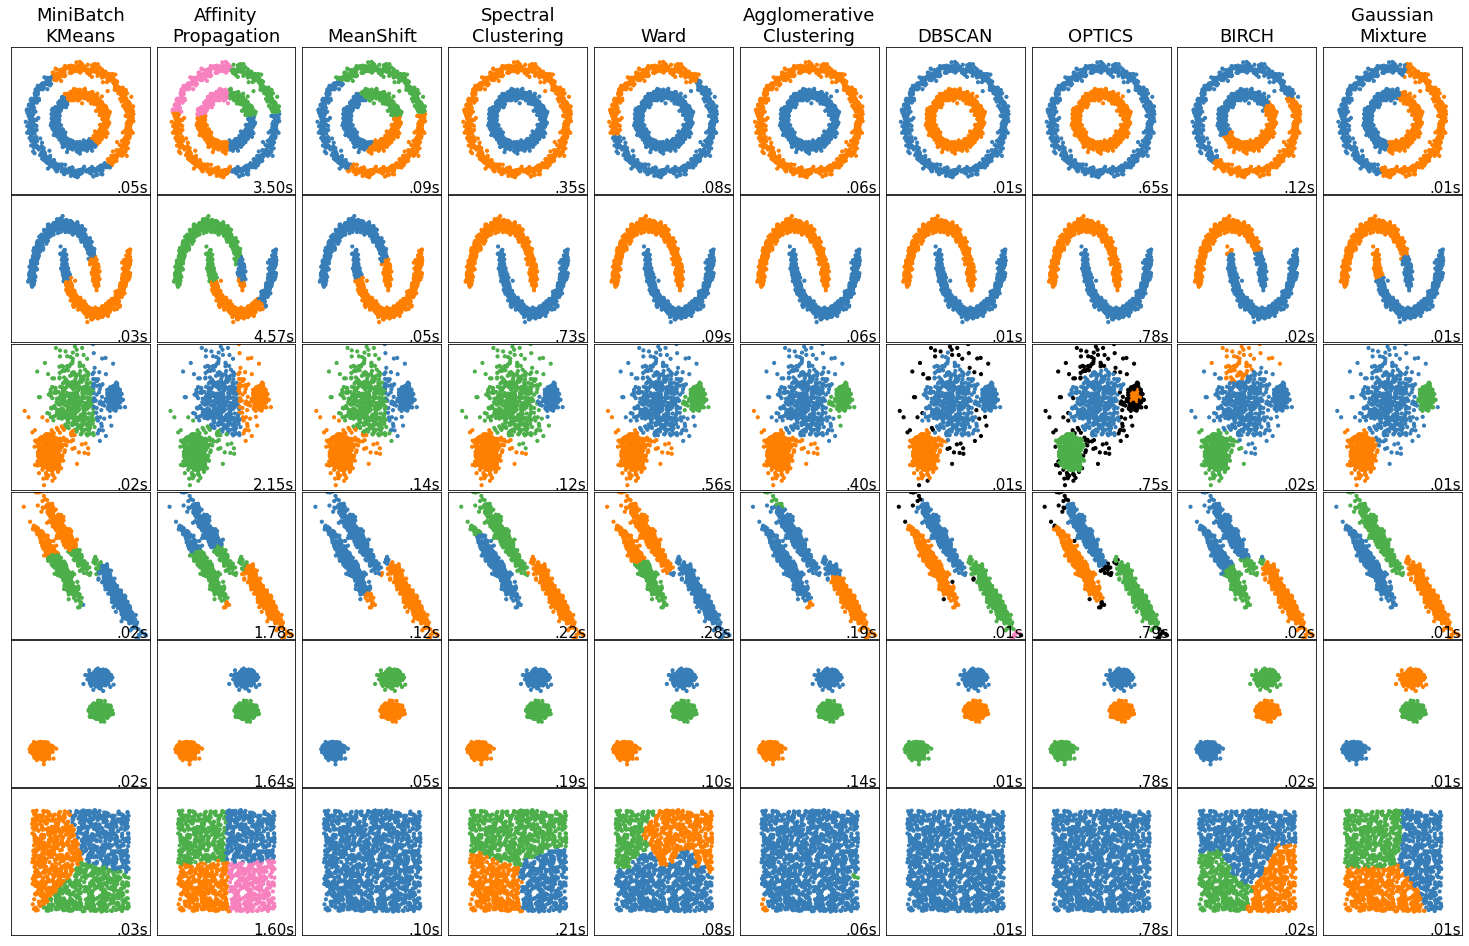

In [1]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 13))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)

plot_num = 1

default_base = {
    "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.9,
    "preference": -200,
    "n_neighbors": 10,
    "n_clusters": 3,
    "min_samples": 20,
    "xi": 0.05,
    "min_cluster_size": 0.1,
}

datasets = [
    (
        noisy_circles,
        {
            "damping": 0.77,
            "preference": -240,
            "quantile": 0.2,
            "n_clusters": 2,
            "min_samples": 20,
            "xi": 0.25,
        },
    ),
    (noisy_moons, {"damping": 0.75, "preference": -220, "n_clusters": 2}),
    (
        varied,
        {
            "eps": 0.18,
            "n_neighbors": 2,
            "min_samples": 5,
            "xi": 0.035,
            "min_cluster_size": 0.2,
        },
    ),
    (
        aniso,
        {
            "eps": 0.15,
            "n_neighbors": 2,
            "min_samples": 20,
            "xi": 0.1,
            "min_cluster_size": 0.2,
        },
    ),
    (blobs, {}),
    (no_structure, {}),
]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params["n_neighbors"], include_self=False
    )
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params["n_clusters"])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"], linkage="ward", connectivity=connectivity
    )
    spectral = cluster.SpectralClustering(
        n_clusters=params["n_clusters"],
        eigen_solver="arpack",
        affinity="nearest_neighbors",
    )
    dbscan = cluster.DBSCAN(eps=params["eps"])
    optics = cluster.OPTICS(
        min_samples=params["min_samples"],
        xi=params["xi"],
        min_cluster_size=params["min_cluster_size"],
    )
    affinity_propagation = cluster.AffinityPropagation(
        damping=params["damping"], preference=params["preference"], random_state=0
    )
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average",
        affinity="cityblock",
        n_clusters=params["n_clusters"],
        connectivity=connectivity,
    )
    birch = cluster.Birch(n_clusters=params["n_clusters"])
    gmm = mixture.GaussianMixture(
        n_components=params["n_clusters"], covariance_type="full"
    )

    clustering_algorithms = (
        ("MiniBatch\nKMeans", two_means),
        ("Affinity\nPropagation", affinity_propagation),
        ("MeanShift", ms),
        ("Spectral\nClustering", spectral),
        ("Ward", ward),
        ("Agglomerative\nClustering", average_linkage),
        ("DBSCAN", dbscan),
        ("OPTICS", optics),
        ("BIRCH", birch),
        ("Gaussian\nMixture", gmm),
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the "
                + "connectivity matrix is [0-9]{1,2}"
                + " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning,
            )
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding"
                + " may not work as expected.",
                category=UserWarning,
            )
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, "labels_"):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
                    ),
                    int(max(y_pred) + 1),
                )
            )
        )
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        plot_num += 1

plt.show()


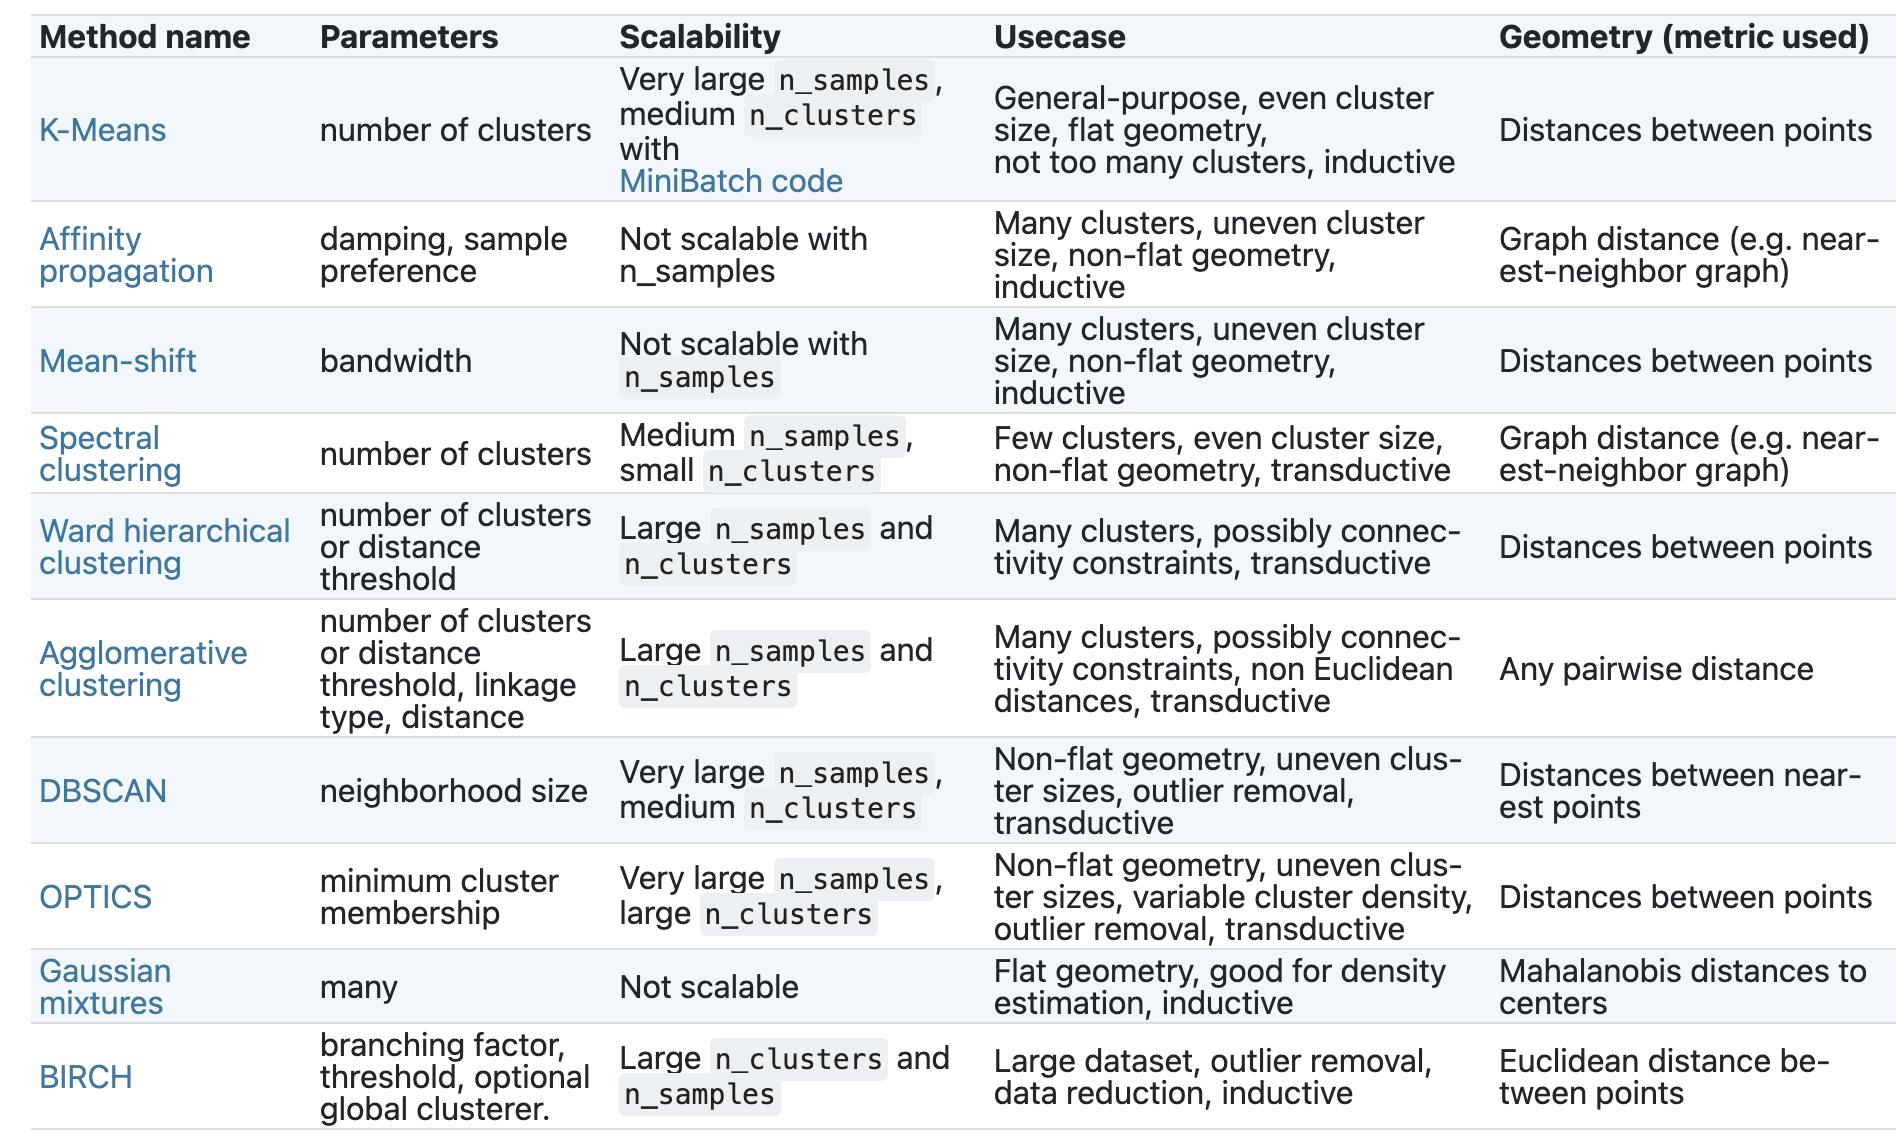

## K-means ##

The KMeans algorithm clusters data by trying to separate samples in n groups of equal variance, minimizing a criterion known as the inertia or within-cluster sum-of-squares (see below). This algorithm requires the number of clusters to be specified. It scales well to large number of samples and has been used across a large range of application areas in many different fields.

The k-means algorithm divides a set of N samples X into N disjoint clusters , each described by the mean Ui
 of the samples in the cluster. The means are commonly called the cluster “centroids”; note that they are not, in general, points from X, although they live in the same space.
 
The K-means algorithm aims to choose centroids that minimise the inertia, or within-cluster sum-of-squares criterion:
 
 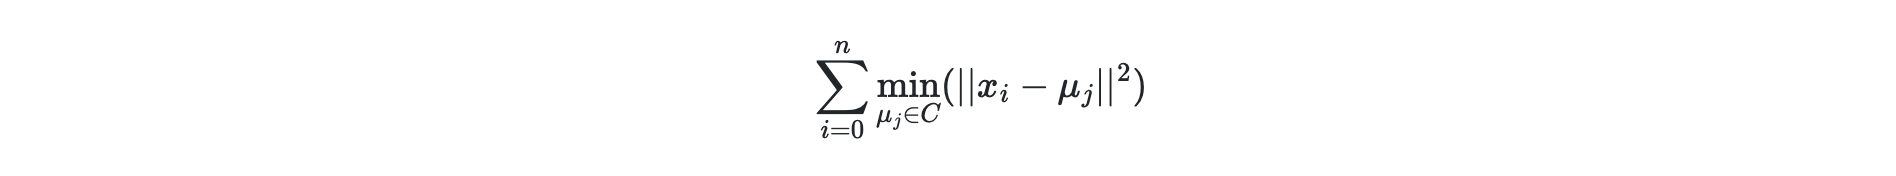
 
 
Inertia can be recognized as a measure of how internally coherent clusters are. It suffers from various drawbacks:

    => Inertia makes the assumption that clusters are convex and isotropic, which is not always the case. It responds poorly to elongated clusters, or manifolds with irregular shapes.

    => Inertia is not a normalized metric: we just know that lower values are better and zero is optimal. But in very high-dimensional spaces, Euclidean distances tend to become inflated (this is an instance of the so-called “curse of dimensionality”). Running a dimensionality reduction algorithm such as Principal component analysis (PCA) prior to k-means clustering can alleviate this problem and speed up the computations.






 ## Mini Batch K-Means ##
 
The MiniBatchKMeans is a variant of the KMeans algorithm which uses mini-batches to reduce the computation time, while still attempting to optimise the same objective function. Mini-batches are subsets of the input data, randomly sampled in each training iteration. These mini-batches drastically reduce the amount of computation required to converge to a local solution. In contrast to other algorithms that reduce the convergence time of k-means, mini-batch k-means produces results that are generally only slightly worse than the standard algorithm.

The algorithm iterates between two major steps, similar to vanilla k-means. In the first step,  samples are drawn randomly from the dataset, to form a mini-batch. These are then assigned to the nearest centroid. In the second step, the centroids are updated. In contrast to k-means, this is done on a per-sample basis. For each sample in the mini-batch, the assigned centroid is updated by taking the streaming average of the sample and all previous samples assigned to that centroid. This has the effect of decreasing the rate of change for a centroid over time. These steps are performed until convergence or a predetermined number of iterations is reached.

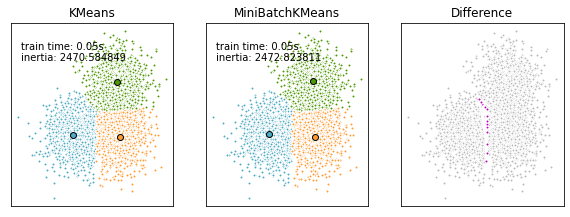

In [2]:
import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.datasets import make_blobs

# #############################################################################
# Generate sample data
np.random.seed(0)

batch_size = 45
centers = [[1, 1], [-1, -1], [1, -1]]
n_clusters = len(centers)
X, labels_true = make_blobs(n_samples=3000, centers=centers, cluster_std=0.7)

# #############################################################################
# Compute clustering with Means

k_means = KMeans(init="k-means++", n_clusters=3, n_init=10)
t0 = time.time()
k_means.fit(X)
t_batch = time.time() - t0

# #############################################################################
# Compute clustering with MiniBatchKMeans

mbk = MiniBatchKMeans(
    init="k-means++",
    n_clusters=3,
    batch_size=batch_size,
    n_init=10,
    max_no_improvement=10,
    verbose=0,
)
t0 = time.time()
mbk.fit(X)
t_mini_batch = time.time() - t0

# #############################################################################
# Plot result

fig = plt.figure(figsize=(8, 3))
fig.subplots_adjust(left=0.02, right=0.98, bottom=0.05, top=0.9)
colors = ["#4EACC5", "#FF9C34", "#4E9A06"]

# We want to have the same colors for the same cluster from the
# MiniBatchKMeans and the KMeans algorithm. Let's pair the cluster centers per
# closest one.
k_means_cluster_centers = k_means.cluster_centers_
order = pairwise_distances_argmin(k_means.cluster_centers_, mbk.cluster_centers_)
mbk_means_cluster_centers = mbk.cluster_centers_[order]

k_means_labels = pairwise_distances_argmin(X, k_means_cluster_centers)
mbk_means_labels = pairwise_distances_argmin(X, mbk_means_cluster_centers)

# KMeans
ax = fig.add_subplot(1, 3, 1)
for k, col in zip(range(n_clusters), colors):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    ax.plot(X[my_members, 0], X[my_members, 1], "w", markerfacecolor=col, marker=".")
    ax.plot(
        cluster_center[0],
        cluster_center[1],
        "o",
        markerfacecolor=col,
        markeredgecolor="k",
        markersize=6,
    )
ax.set_title("KMeans")
ax.set_xticks(())
ax.set_yticks(())
plt.text(-3.5, 1.8, "train time: %.2fs\ninertia: %f" % (t_batch, k_means.inertia_))

# MiniBatchKMeans
ax = fig.add_subplot(1, 3, 2)
for k, col in zip(range(n_clusters), colors):
    my_members = mbk_means_labels == k
    cluster_center = mbk_means_cluster_centers[k]
    ax.plot(X[my_members, 0], X[my_members, 1], "w", markerfacecolor=col, marker=".")
    ax.plot(
        cluster_center[0],
        cluster_center[1],
        "o",
        markerfacecolor=col,
        markeredgecolor="k",
        markersize=6,
    )
ax.set_title("MiniBatchKMeans")
ax.set_xticks(())
ax.set_yticks(())
plt.text(-3.5, 1.8, "train time: %.2fs\ninertia: %f" % (t_mini_batch, mbk.inertia_))

# Initialise the different array to all False
different = mbk_means_labels == 4
ax = fig.add_subplot(1, 3, 3)

for k in range(n_clusters):
    different += (k_means_labels == k) != (mbk_means_labels == k)

identic = np.logical_not(different)
ax.plot(X[identic, 0], X[identic, 1], "w", markerfacecolor="#bbbbbb", marker=".")
ax.plot(X[different, 0], X[different, 1], "w", markerfacecolor="m", marker=".")
ax.set_title("Difference")
ax.set_xticks(())
ax.set_yticks(())

plt.show()

## Mean Shift ##

MeanShift clustering aims to discover blobs in a smooth density of samples. It is a centroid based algorithm, which works by updating candidates for centroids to be the mean of the points within a given region. These candidates are then filtered in a post-processing stage to eliminate near-duplicates to form the final set of centroids.

Given a candidate centroid xi,j for iteration , the candidate is updated according to the following equation:

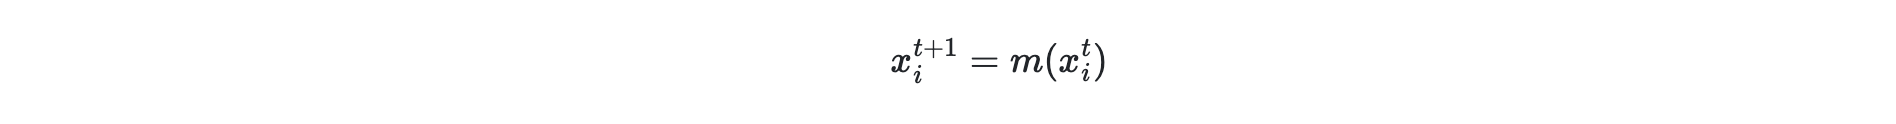

Where N(xi) is the neighborhood of samples within a given distance around Xi, and M is the mean shift vector that is computed for each centroid that points towards a region of the maximum increase in the density of points. This is computed using the following equation, effectively updating a centroid to be the mean of the samples within its neighborhood:

## Hierarchical clustering ##

Hierarchical clustering is a general family of clustering algorithms that build nested clusters by merging or splitting them successively. This hierarchy of clusters is represented as a tree (or dendrogram). The root of the tree is the unique cluster that gathers all the samples, the leaves being the clusters with only one sample. 

The AgglomerativeClustering object performs a hierarchical clustering using a bottom up approach: each observation starts in its own cluster, and clusters are successively merged together. The linkage criteria determines the metric used for the merge strategy:

    1) Ward minimizes the sum of squared differences within all clusters. It is a variance-minimizing approach and in this sense is similar to the k-means objective function but tackled with an agglomerative hierarchical approach.

    2) Maximum or complete linkage minimizes the maximum distance between observations of pairs of clusters.

    3) Average linkage minimizes the average of the distances between all observations of pairs of clusters.

    4) Single linkage minimizes the distance between the closest observations of pairs of clusters.
    
    
#### Different linkage type: Ward, complete, average, and single linkage

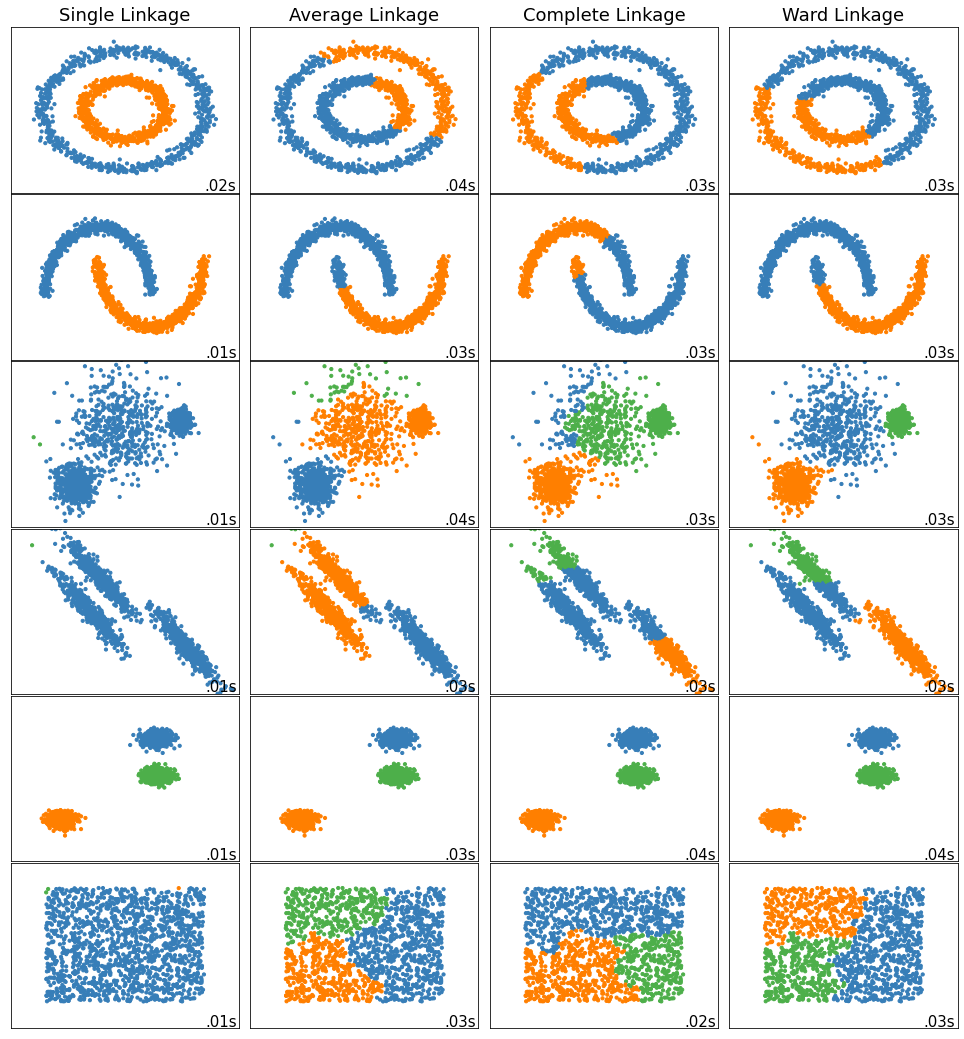

In [3]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

# Set up cluster parameters
plt.figure(figsize=(9 * 1.3 + 2, 14.5))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.96, wspace=0.05, hspace=0.01
)

plot_num = 1

default_base = {"n_neighbors": 10, "n_clusters": 3}

datasets = [
    (noisy_circles, {"n_clusters": 2}),
    (noisy_moons, {"n_clusters": 2}),
    (varied, {"n_neighbors": 2}),
    (aniso, {"n_neighbors": 2}),
    (blobs, {}),
    (no_structure, {}),
]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # ============
    # Create cluster objects
    # ============
    ward = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"], linkage="ward"
    )
    complete = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"], linkage="complete"
    )
    average = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"], linkage="average"
    )
    single = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"], linkage="single"
    )

    clustering_algorithms = (
        ("Single Linkage", single),
        ("Average Linkage", average),
        ("Complete Linkage", complete),
        ("Ward Linkage", ward),
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the "
                + "connectivity matrix is [0-9]{1,2}"
                + " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning,
            )
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, "labels_"):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
                    ),
                    int(max(y_pred) + 1),
                )
            )
        )
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        plot_num += 1

plt.show()

### Plot Hierarchical Clustering Dendrogram 

This example plots the corresponding dendrogram of a hierarchical clustering using AgglomerativeClustering and the dendrogram method available in scipy.

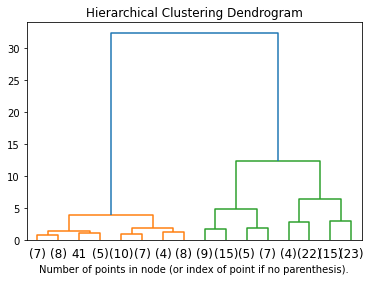

In [4]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


iris = load_iris()
X = iris.data

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()